In [195]:
import numpy as np
from matplotlib import pyplot as plt 
import matplotlib as mpl
from matplotlib import rc
from ipywidgets import interact, widgets
from IPython.display import display
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import pandas as pd
import pywt
import itertools
from scipy.signal import hilbert,spectrogram
plt.style.use('default')
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'],'size':20})
rc('text', usetex=False)
rc('axes', titlesize=18, labelsize=20)
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16

In [2]:
data_path = '/Users/localadmin/Desktop/Fluidlab/Projects/Sonnen_lab/Oscillators/'

df = pd.read_csv(data_path+'tracks.csv')
df = df.sort_values(by=['track ID','time'])

## Positions

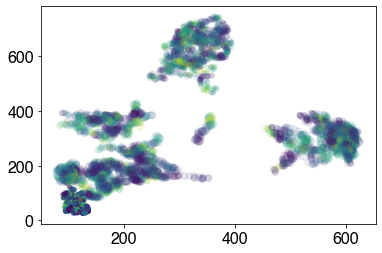

In [3]:
plt.figure()
for idx,f in df.groupby('track ID'):
    plt.scatter(f.x,f.y,c=f.Hes1_normalized_signal, s=f.z/8,alpha=.1)

## Raw Data

Text(0.5, 0, '$\\mathrm{Time}\\,\\mathrm{[h]}$')

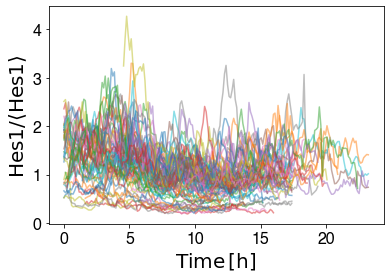

In [4]:
plt.figure()
for idx,f in df.groupby('track ID'):
    plt.plot(f.time,f.Hes1_normalized_signal,alpha=.5)

plt.ylabel(r'$\mathrm{Hes1}/\langle \mathrm{Hes1}\rangle$')
plt.xlabel(r'$\mathrm{Time}\,\mathrm{[h]}$')

# Measure the entire spectrum 

we find that the spectrum follows roughly a $P(f) \propto f^{-\alpha}$ curve in which $\alpha=2$ which corresponds to Brownian Noise the noise from an integrated Wiener process

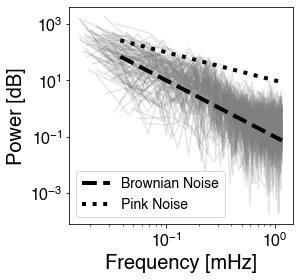

In [5]:
Fouriers = []
Freqs    = []
fig,ax = plt.subplots(figsize=(4,4))
for idx,f in df.groupby('track ID'):
    fourier = np.fft.fft(f.Hes1_normalized_signal)
    freq = np.fft.fftfreq(f.time.shape[-1])*1000./(3600*f.time.diff().mean()) #time.diff in hrs 
    signalPSD = np.absolute(fourier)**2
    ax.loglog(freq[freq>0],signalPSD[freq>0],c='gray',alpha=.2)
a=2
ax.loglog(freq[freq>0],.1/freq[freq>0]**a,c='k',lw=4,ls='--',label='Brownian Noise')
a=1
ax.loglog(freq[freq>0],10/freq[freq>0]**a,c='k',lw=4,ls=':',label='Pink Noise')
ax.set_ylabel('Power [dB]')
ax.set_xlabel('Frequency [mHz]')
ax.legend(fontsize=14)

# Autocorrelation of the signals

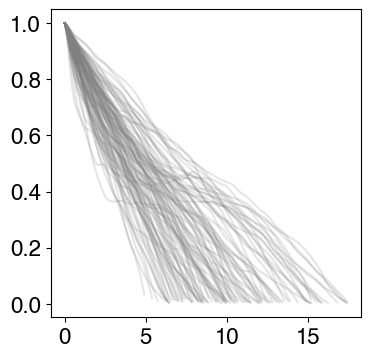

In [15]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[int(result.size/2):]


fig,ax = plt.subplots(figsize=(4,4))
for idx,f in df.groupby('track ID'):
    auto_corr = autocorr(f.Hes1_normalized_signal)
    ax.plot(np.arange(len(auto_corr))*f.time.diff().mean(),auto_corr/auto_corr[0],c='gray',alpha=.2)

(8, 12)


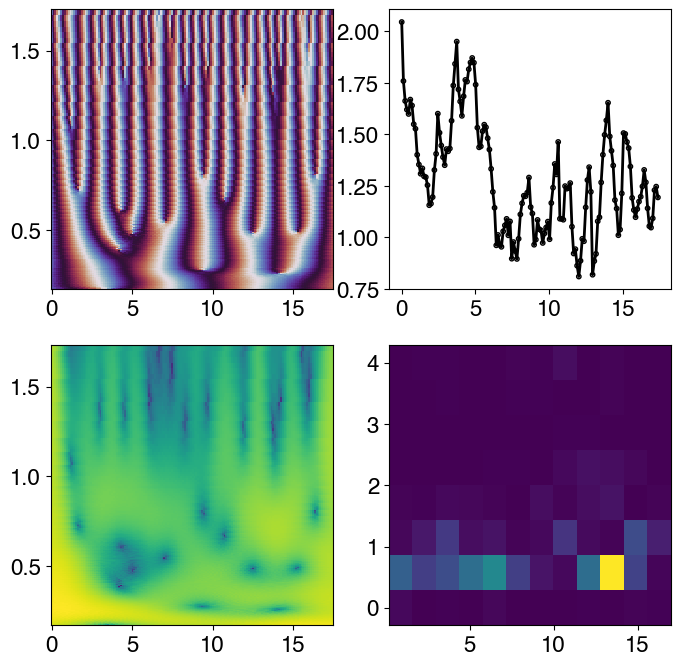

In [180]:
widths = np.arange(5, 51,.1)
f= df[df['track ID']==10]
cwtmatr, freqs = pywt.cwt(f.Hes1_normalized_signal,widths , 'cmor1.0-1.0')
dt = f.time.diff().mean()
frequencies = pywt.scale2frequency('cmor1.0-1.0', widths) / dt
cwtmatr = np.asarray(cwtmatr)
angles = np.angle(cwtmatr)
absolutes = np.abs(cwtmatr)
freq,t,Sxx = spectrogram(f.Hes1_normalized_signal,1/dt,noverlap=3,nperseg=15)
print(Sxx.shape)


fig,ax = plt.subplots(2,2,figsize=(8,8))
ax[0][0].pcolormesh(f.time,frequencies,angles,cmap='twilight')
ax[1][0].pcolormesh(f.time,frequencies,np.log10(absolutes))
ax[0][1].plot(f.time,f.Hes1_normalized_signal,c='k',lw=2)
ax[0][1].scatter(f.time,f.Hes1_normalized_signal,s=10,zorder=10,facecolors='None',edgecolors='k',lw=1)
ax[1][1].pcolormesh(t,freq,Sxx)
plt.show()

In [86]:
def Inter_Trial_Phase_Clustering(df,widths = np.arange(2, 31,0.1),wavelet='cmor1.0-1.0'):
    """Calculates inter Trial phase clustering:
       taking a morley wavelet transform of every trajectory to extract phase angles for all tracks and times and frequencies
       calculating cos(theta) and sin(theta) and padding them according to start and end times into a matrix
       averaging the nanmeans of all matrices (all trajectories)

    Args:
        df (pd.dataframe): Tracks data containing signal
        widths (np.array, optional): Widths for wavelet trafo. Defaults to np.arange(2, 31,0.1).
        wavelet (str, optional): Wavelet for wavelet transform, should be an object of pywt. Defaults to 'cmor1.0-1.0'.

    Returns:
        frequencies, time, ITPC
    """
    angles     = []
    cos_angles = []
    sin_angles = []
    absolutes  = []
    times      = []

    for idx,f in df.groupby('track ID'):
        cwtmatr, freqs = pywt.cwt(f.Hes1_normalized_signal,widths ,wavelet)
        cwtmatr = np.asarray(cwtmatr)
        angles.append(np.angle(cwtmatr))
        cos_angles.append(np.cos(np.angle(cwtmatr)))
        sin_angles.append(np.sin(np.angle(cwtmatr)))
        absolutes.append(np.abs(cwtmatr))
        times.append(np.asarray(f.timepoint.array))
    dt = f.time.diff().mean()

    max_length = max(arr.shape[1] for arr in cos_angles)
    max_time   = df.timepoint.max()
    min_time   = df.timepoint.min()
    # Pad arrays to ensure they all have the same length

    #NEEDS CORRECTION AS TRAJECTORIES START AT DIFFERENT TIMES!
    frequencies = pywt.scale2frequency(wavelet, widths) / dt
    padded_cos_angles = [np.pad(arr, ((0, 0), (t[0]-min_time, max_time- t[-1])), mode='constant', constant_values=np.nan) for arr,t in zip(cos_angles,times)]
    padded_sin_angles = [np.pad(arr, ((0, 0), (t[0]-min_time, max_time- t[-1])), mode='constant', constant_values=np.nan) for arr,t in zip(sin_angles,times)]


    times = np.sort(df.time.unique())



    ITPC = np.sqrt(np.nanmean(padded_cos_angles,axis=0)**2+np.nanmean(padded_sin_angles,axis=0)**2)
    return frequencies,times,ITPC


def Inter_Site_Phase_Clustering(df,widths = np.arange(2, 31,0.1),wavelet='cmor1.0-1.0'):
    """Calculates inter Trial phase clustering:
       taking a morley wavelet transform of every trajectory to extract phase angles for all tracks and times and frequencies
       calculating cos(theta) and sin(theta) and padding them according to start and end times into a matrix
       averaging the nanmeans of all matrices (all trajectories)

    Args:
        df (pd.dataframe): Tracks data containing signal
        widths (np.array, optional): Widths for wavelet trafo. Defaults to np.arange(2, 31,0.1).
        wavelet (str, optional): Wavelet for wavelet transform, should be an object of pywt. Defaults to 'cmor1.0-1.0'.

    Returns:
        frequencies, time, ITPC
    """
    #create pairs numbers
    pair_nums = list(set(list(itertools.combinations(f['track ID'].unique(), 2))))



    angles     = []
    cos_angles = []
    sin_angles = []
    absolutes  = []
    times      = []

    for idx,f in df.groupby('track ID'):
        cwtmatr, freqs = pywt.cwt(f.Hes1_normalized_signal,widths , wavelet)
        cwtmatr = np.asarray(cwtmatr)
        angles.append(np.angle(cwtmatr))
        cos_angles.append(np.cos(np.angle(cwtmatr)))
        sin_angles.append(np.sin(np.angle(cwtmatr)))
        absolutes.append(np.abs(cwtmatr))
        times.append(np.asarray(f.timepoint.array))
    dt = f.time.diff().mean()

    max_time   = df.timepoint.max()
    min_time   = df.timepoint.min()
    # Pad arrays to ensure they all have the same length

    #NEEDS CORRECTION AS TRAJECTORIES START AT DIFFERENT TIMES!
    frequencies = pywt.scale2frequency(wavelet, widths) / dt
    padded_cos_angles = [np.pad(arr, ((0, 0), (t[0]-min_time, max_time- t[-1])), mode='constant', constant_values=np.nan) for arr,t in zip(cos_angles,times)]
    padded_sin_angles = [np.pad(arr, ((0, 0), (t[0]-min_time, max_time- t[-1])), mode='constant', constant_values=np.nan) for arr,t in zip(sin_angles,times)]


    times = np.sort(df.time.unique())



    ITPC = np.sqrt(np.nanmean(padded_cos_angles,axis=0)**2+np.nanmean(padded_sin_angles,axis=0)**2)
    return frequencies,times,ISPC


Text(0, 0.5, 'Frequency [A.U.]')

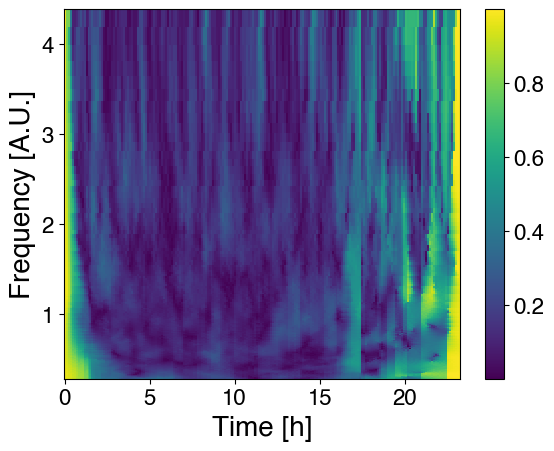

In [170]:
frequencies,times,ITPC = Inter_Trial_Phase_Clustering(df)
plt.pcolormesh(times,frequencies,ITPC)
plt.colorbar()
plt.xlabel('Time [h]')
plt.ylabel('Frequency [A.U.]')

# Cluster trajectories based on their position

In [106]:
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

In [143]:
def plot_clusters(X, labels, probabilities=None, parameters=None, ground_truth=False, ax=None):
    if ax is None:
        _, ax = plt.subplots(figsize=(10, 4))
    labels = labels if labels is not None else np.ones(X.shape[0])
    probabilities = probabilities if probabilities is not None else np.ones(X.shape[0])
    # Black removed and is used for noise instead.
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    # The probability of a point belonging to its labeled cluster determines
    # the size of its marker
    proba_map = {idx: probabilities[idx] for idx in range(len(labels))}
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_index = np.where(labels == k)[0]
        for ci in class_index:
            ax.plot(
                X[ci, 0],
                X[ci, 1],
                "x" if k == -1 else "o",
                markerfacecolor=tuple(col),
                markeredgecolor="k",
                markersize=4 if k == -1 else 1 + 5 * proba_map[ci],
            )
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    preamble = "True" if ground_truth else "Estimated"
    title = f"{preamble} number of clusters: {n_clusters_}"
    if parameters is not None:
        parameters_str = ", ".join(f"{k}={v}" for k, v in parameters.items())
        title += f" | {parameters_str}"
    ax.set_title(title)
    plt.tight_layout()

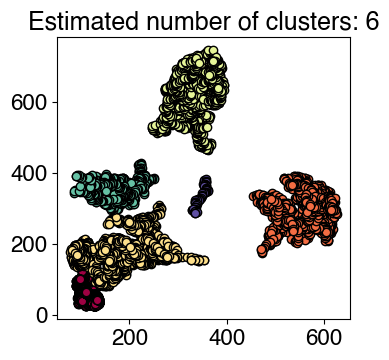

In [144]:
f =df
X = np.asarray([f.x, f.y, f.z]).T
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
dbs = DBSCAN(eps=30,min_samples=4)
dbfit=dbs.fit(X)
plot_clusters(X,dbfit.labels_,ax=ax)
df['DBSCAN_label'] =dbfit.labels_

In [135]:
DBlabel_group = df.groupby(['track ID']).aggregate(trackID=('track ID', 'max'),DBSCAN_label=('DBSCAN_label', 'max'))
print(DBlabel_group)
track_IDs_by_label= DBlabel_group[DBlabel_group.DBSCAN_label==0].trackID.array

          trackID  DBSCAN_label
track ID                       
1               1             0
2               2             0
3               3             0
4               4             0
5               5             0
...           ...           ...
113           113             4
114           114             3
115           115             3
116           116             3
117           117             2

[107 rows x 2 columns]


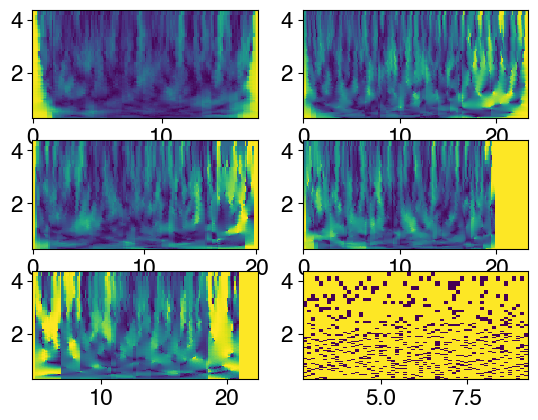

In [137]:
size = DBlabel_group.DBSCAN_label.max()
fig,ax = plt.subplots(3,2)

for i in range(size+1):
    track_IDs_by_label= DBlabel_group[DBlabel_group.DBSCAN_label==i].trackID.array
    f= df[df['track ID'].isin(track_IDs_by_label)]
    freq,time,ITPC = Inter_Trial_Phase_Clustering(f)
    ax.ravel()[i].pcolormesh(time,freq,ITPC)


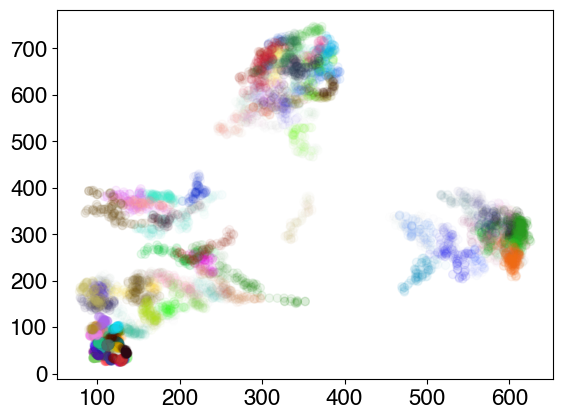

In [82]:
plt.scatter(df.x,df.y,c=df['track ID'],alpha=df.time/200,cmap= mpl.colors.ListedColormap ( np.random.rand ( 256,3)))


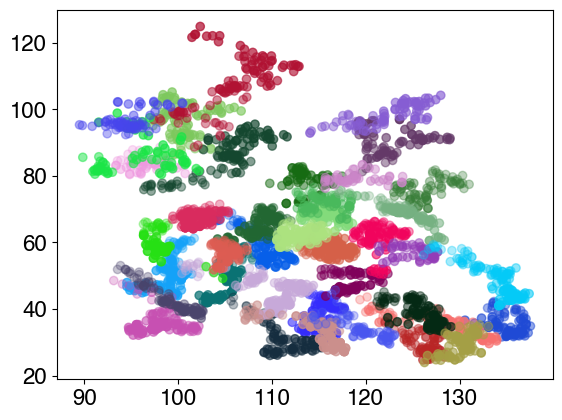

In [192]:
f= df[df['track ID'].isin(DBlabel_group[DBlabel_group.DBSCAN_label==0].trackID.array)]
plt.scatter(f.x,f.y,c=f['track ID'],alpha=0.3+0.3/(1-0.3)*f.time/f.time.max(),cmap=mpl.colors.ListedColormap ( np.random.rand ( 256,3)))

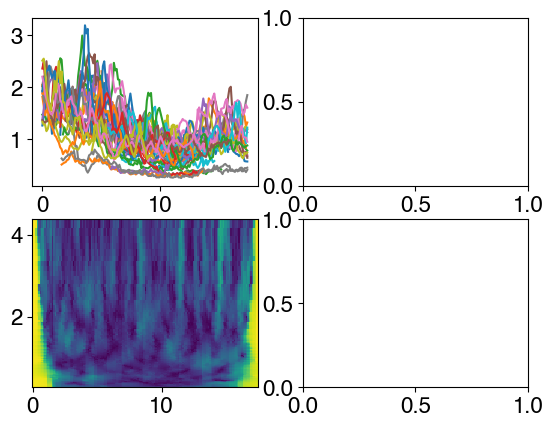

In [194]:
fig,ax = plt.subplots(2,2)

for i,subs in f.groupby('track ID'):
    ax[0,0].plot(subs.time,subs.Hes1_normalized_signal)
    freq,time,ITPC = Inter_Trial_Phase_Clustering(f)
    ax[1,0].pcolormesh(time,freq,ITPC)


I clearly see some similarities between trajectories, but it remains illusive what the exact relationship is. 
Especially the trend is correlated but this is probably a simple base-line effect.